In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals, Circle
from src.CommonObservables import buildCommmonObservables


# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster




# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 



/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

(250000, 200, 3)
(250000, 200, 3)
652.7005


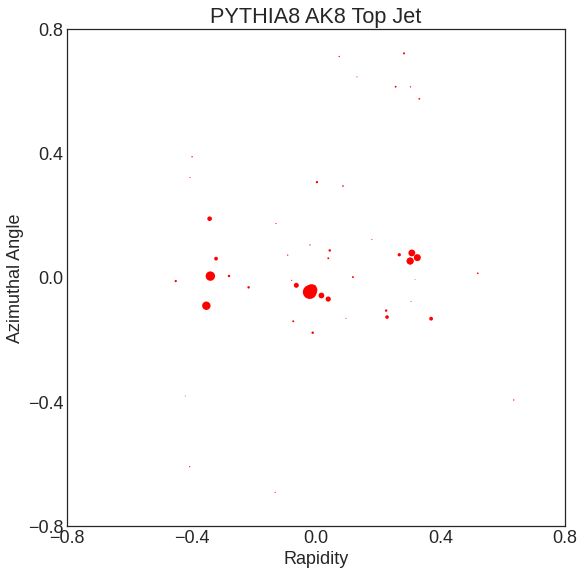

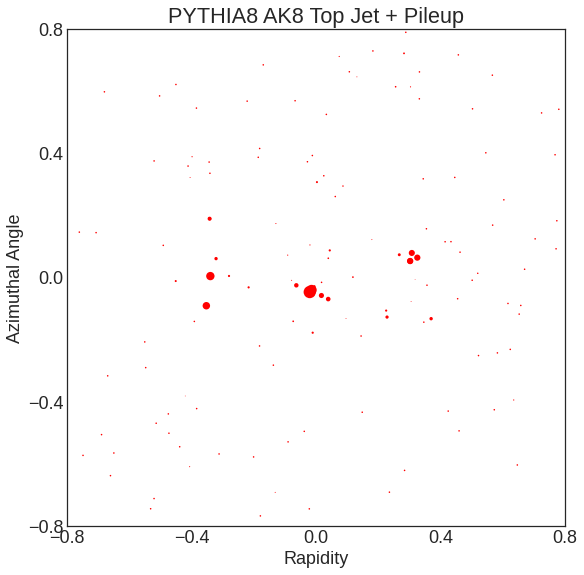

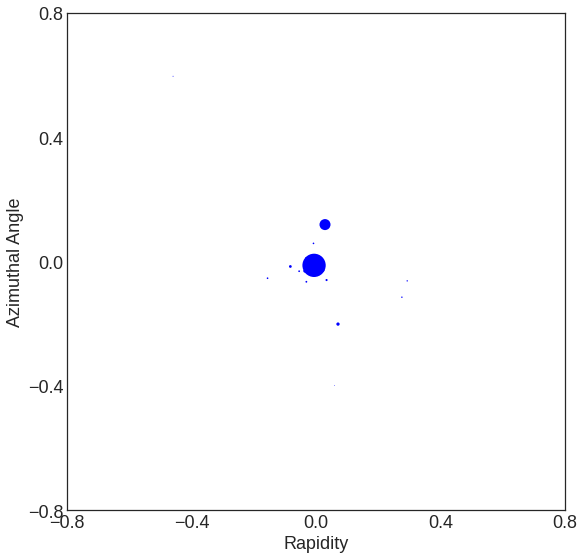

175.73739592767245 25.133976560873414
293.7238283795816 47.785981096556206


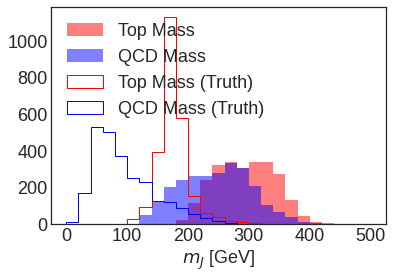

Parameter containing:
tensor([-0.4749, -0.4749, -0.4749], requires_grad=True)


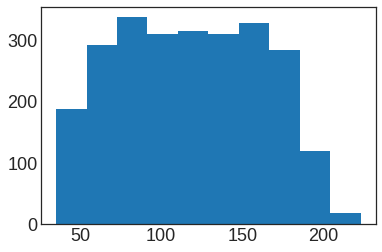

In [2]:
# Parameters
R = 0.8
beta = 1
N = 2500
batch_size = 500

mass_lower = 0
mass_upper = np.inf
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)




# Add pileup
signal_pu, signal_norms1 = normalize_events(add_pileup(signal, 100, 50, 250, .25, R), return_norm= True)
background_pu, background_norms = normalize_events(add_pileup(background, 100, 50, 250, .25, R), return_norm= True)
signal_pu_mass = signal_norms1 * calculate_masses(signal_pu)
background_pu_mass = background_norms * calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

print(np.mean(signal_mass), np.std(signal_mass))
print(np.mean(signal_pu_mass), np.std(signal_pu_mass))


plt.hist(signal_pu_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(background_pu_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(signal_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass (Truth)", alpha = 1.0, histtype="step")
plt.hist(background_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass (Truth)", alpha = 1.0, histtype="step")
plt.legend(loc = "upper left")
plt.xlabel(r"$m_J$ [GeV]")
plt.show()


plt.hist(signal_pu_mass - signal_mass)


# Circle
circle = Circle(3, initializer = 8)
circle.enforce()
print(circle.params)



In [3]:
from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection
from src.CommonObservables import buildCommmonObservables



# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

def point_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):

        # Center
        ax.scatter(centers[i, 0], centers[i, 1], color="Purple", label="Disk", marker="x", s=2 * weights[i] * 500/np.sum(weights), alpha=0.75, zorder=15, lw=3)

        # Text
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z: %.2f" % (centers[i, 0], centers[i, 1], weights[i]), fontsize=18, transform=plt.gca().transAxes)

# Disk

def ring_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis=1) * radii[:, None, None] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = points.T
    z = torch.cat([weights[i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    return (e, z)

def ring_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i, :], radii[i], fill=False, edgecolor="purple", alpha=0.5, zorder=11,)
        ax.add_artist(draw_circle)

        # Text
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z: %.2f, Rad: %.2f" %
                    (centers[i, 0], centers[i, 1], weights[i], radii[i]), fontsize=18, transform=plt.gca().transAxes)

# Disk

def disk_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    r = torch.sqrt(torch.rand(num, N)).to(device)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis=1) * radii[:, None, None] * r[:, None, :] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = points.T
    z = torch.cat([weights[i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    return (e, z)

def disk_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i, :], radii[i], facecolor="purple", edgecolor="purple", alpha=0.25, zorder=11,)
        ax.add_artist(draw_circle)

        # Text
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z: %.2f, Rad: %.2f" %
                    (centers[i, 0], centers[i, 1], weights[i], radii[i]), fontsize=18, transform=plt.gca().transAxes)

# Disk

def ellipse_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii1 = param_dict["Radius1"].params
    radii2 = param_dict["Radius2"].params
    angles = param_dict["Angles"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    r = torch.sqrt(torch.rand(num, N)).to(device)

    x0 = radii1[:, None] * torch.cos(phi)
    y0 = radii2[:, None] * torch.sin(phi)
    x = x0*torch.cos(angles[:, None]) - y0*torch.sin(angles[:, None])
    y = x0*torch.sin(angles[:, None]) + y0*torch.cos(angles[:, None])
    points = torch.stack([x, y], axis=1) * r[:, None, :] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = points.T
    z = torch.cat([weights[i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    return (e, z)

def ellipse_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii1 = param_dict["Radius1"].params.clone().detach().numpy()
    radii2 = param_dict["Radius2"].params.clone().detach().numpy()
    angles = param_dict["Angles"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltEllipse(centers[i, :], 2*radii1[i], 2*radii2[i], angle=angles[i] * 180 / np.pi, facecolor="purple", edgecolor="purple", alpha=0.25, zorder=11,)
        ax.add_artist(draw_circle)

        # Text
        eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z: %.2f, Rad: %.2f, Ecc. %.2f" %
                    (centers[i, 0], centers[i, 1], weights[i], np.sqrt(radii1[i] * radii2[i]), eccentricity), fontsize=18, transform=plt.gca().transAxes)

# Point plus disk

def point_ring_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis=1) * radii[:, None, None] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = torch.cat([centers, points.T], dim=0)
    z1 = torch.cat([weights[i] * torch.ones((1,), device=device) for i in range(num)], dim=0)
    z2 = torch.cat([weights[num + i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    z = torch.cat([z1, z2], dim=0)
    return (e, z)

def point_ring_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i, :], radii[i], fill=False, edgecolor="purple", alpha=0.5, zorder=11,)
        ax.add_artist(draw_circle)

        # Center
        ax.scatter(centers[i, 0], centers[i, 1], color="Purple",  marker="x", s=2 * weights[i] * 500/np.sum(weights), alpha=0.5, zorder=15, lw=3)

        # Text
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f), Rad: %.2f" %
                    (centers[i, 0], centers[i, 1], weights[i], weights[i+num], radii[i]), fontsize=18, transform=plt.gca().transAxes)

# Point plus disk

def point_disk_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    r = torch.sqrt(torch.rand(num, N)).to(device)
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis=1) * radii[:, None, None] * r[:, None, :] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = torch.cat([centers, points.T], dim=0)
    z1 = torch.cat([weights[i] * torch.ones((1,), device=device) for i in range(num)], dim=0)
    z2 = torch.cat([weights[num + i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    z = torch.cat([z1, z2], dim=0)
    return (e, z)

def point_disk_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i, :], radii[i], facecolor="purple", edgecolor="purple", alpha=0.25, zorder=11,)
        ax.add_artist(draw_circle)

        # Center
        ax.scatter(centers[i, 0], centers[i, 1], color="Purple",  marker="x", s=2 * weights[i] * 500/np.sum(weights), alpha=0.5, zorder=15, lw=3)

        # Text
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f), Rad: %.2f" %
                    (centers[i, 0], centers[i, 1], weights[i], weights[i+num], radii[i]), fontsize=18, transform=plt.gca().transAxes)

# Point plus disk

def point_ellipse_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii1 = param_dict["Radius1"].params
    radii2 = param_dict["Radius2"].params
    angles = param_dict["Angles"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    r = torch.sqrt(torch.rand(num, N)).to(device)

    x0 = radii1[:, None] * torch.cos(phi)
    y0 = radii2[:, None] * torch.sin(phi)
    x = x0*torch.cos(angles[:, None]) - y0*torch.sin(angles[:, None])
    y = x0*torch.sin(angles[:, None]) + y0*torch.cos(angles[:, None])
    points = torch.stack([x, y], axis=1) * r[:, None, :] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = torch.cat([centers, points.T], dim=0)
    z1 = torch.cat([weights[i] * torch.ones((1,), device=device) for i in range(num)], dim=0)
    z2 = torch.cat([weights[num + i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    z = torch.cat([z1, z2], dim=0)
    return (e, z)

def point_ellipse_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii1 = param_dict["Radius1"].params.clone().detach().numpy()
    radii2 = param_dict["Radius2"].params.clone().detach().numpy()
    angles = param_dict["Angles"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltEllipse(centers[i, :], 2*radii1[i], 2*radii2[i], angle=angles[i] * 180 / np.pi, facecolor="purple", edgecolor="purple", alpha=0.25, zorder=11,)
        ax.add_artist(draw_circle)

        # Center
        ax.scatter(centers[i, 0], centers[i, 1], color="Purple",  marker="x", s=2 * weights[i] * 500/np.sum(weights), alpha=0.5, zorder=15, lw=3)

        # Text
        eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.10 + 0.05*i, s + r"Eff. Rad: %.2f, Ecc: %.2f, z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (
            np.sqrt(radii1[i] * radii2[i]), eccentricity, weights[i], weights[i+num], ), fontsize=18, transform=plt.gca().transAxes)
# Sample from a normalized uniform distribution

def uniform_sampler(N, param_dict):
    points = torch.FloatTensor(N, 2).uniform_(-R, R).to(device)

    zs = torch.ones((N,)).to(device) / N
    return (points, zs)




n = 3
commonObservables, obsarray = buildCommmonObservables(3, 1, R, device)
_3subjettiness = commonObservables["3-Subjettiness"]
_3point_diskiness = commonObservables["3-Point-Diskiness"]
_3point_ellipsiness = commonObservables["3-Point-Ellipsiness"]


# Build isotropy and PU observables
_isotropy = Observable({}, uniform_sampler, beta = 1, R = 0.8)
_3subjettiness_plus_pileup = (_3subjettiness + _isotropy)
_3point_diskiness_plus_pileup = (_3point_diskiness + _isotropy)
_3point_ellipsiness_plus_pileup = (_3point_ellipsiness + _isotropy)


plot_dictionary = {
    "plot_directory" : "Plots/Test",
    "gif_directory" : "Plots/gifs",  
    "extension" : "png",
}


observables = {
    "3-Subjettiness" : _3subjettiness,
    # "3-Diskiness" : _3diskiness,
    "3-Point-Diskiness" : _3point_diskiness,
    # "3-Point-Ellipsiness" : _3point_ellipsiness,
    "3-Subjettiness Plus Pileup" : _3subjettiness_plus_pileup,
    # "3-Diskiness Plus Pileup" : _3diskiness_plus_pileup,
    "3-Point-Diskiness Plus Pileup" : _3point_diskiness_plus_pileup,
    # "3-Point-Ellipsiness Plus Pileup" : _3point_ellipsiness_plus_pileup,
}

shaper = Shaper(observables, device)

batch_size = min(batch_size, N)
batches = int(N / batch_size)


for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size

    # cms_emds, cms_params = shaper.calculate(signal_pu[start:end], epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.005, early_stopping= 25, plot_dictionary=None)
    # np.save('test', cms_params)

BATCH: 0
BATCH: 1
BATCH: 2
BATCH: 3
BATCH: 4


In [4]:
pa = np.load('test.npy', allow_pickle = True)[()]
print(pa["3-Subjettiness"][0])

{'Points': array([[-0.02014682, -0.04766558],
       [ 0.3056229 ,  0.05847054],
       [-0.34394285,  0.00347503]], dtype=float32), 'Weights': array([0.46453157, 0.29571798, 0.23975049], dtype=float32)}


In [5]:
pileup = True
pu_string = "PU" if pileup else "no_PU"



# params1 = np.load('data2/batch_0_%s.npy' % pu_string, allow_pickle = True)[()]
# params2 = np.load('data2/batch_1_%s.npy' % pu_string, allow_pickle = True)[()]

mass_dict = {}
pileup_dict = {}





# def masses_load(pa):
#     for obs in observables:

#         zs = []
#         events = []
#         event_parameters =  pa[obs]
#         pileup_factor = np.zeros((N,))


#         # Subtract pileup
#         is_pileup_corrected = "Plus Pileup" in obs
#         if is_pileup_corrected:
#             corrected_obs = obs[:-12]
#         else:
#             corrected_obs = obs

#         for i in range(N):
#             param_dict = event_parameters[i]
#             e, z = observables[corrected_obs].sample(250, param_dict)
#             events.append((e.detach().numpy(), z.detach().numpy()))
#             if is_pileup_corrected:
#                 pileup_factor[i] = (param_dict["Joint Weights"])[1]

#         masses = (1 - pileup_factor) * signal_norms1 * calculate_masses(events)
#         mass_dict[obs] = masses
#         # print(pileup_factor)
#         pileup_dict[obs] = pileup_factor

# masses_load(params1)
# masses_load(params2)


# print(mass_dict["3-Subjettiness"].shape)

# mass_dict = np.load("data/masses_%s.npy" % pu_string, allow_pickle=True)[()]
# pileup_dict = np.load("data/pileup_dict_%s.npy" % pu_string, allow_pickle=True)[()]
# signal_norms = np.load("data/signal_norms.npy")

dict_keys(['3-Subjettiness', '3-Point-Diskiness', '3-Point-Ellipsiness', '3-Point-Gaussiness', '3-Subjettiness Plus Pileup', '3-Point-Diskiness Plus Pileup', '3-Point-Ellipsiness Plus Pileup', '3-Point-Gaussiness Plus Pileup', 'Truth', 'Uncorrected']) dict_keys(['3-Subjettiness', '3-Point-Diskiness', '3-Point-Ellipsiness', '3-Point-Gaussiness', '3-Subjettiness Plus Pileup', '3-Point-Diskiness Plus Pileup', '3-Point-Ellipsiness Plus Pileup', '3-Point-Gaussiness Plus Pileup'])
3-Subjettiness -12.502183602225841 25.521814772860004
3-Point-Diskiness -5.501950834603804 25.3028055374107
3-Subjettiness Plus Pileup -23.049087039878515 24.089347608454606
3-Point-Diskiness Plus Pileup -18.693792328009522 23.846479150269815
175.85013855694376


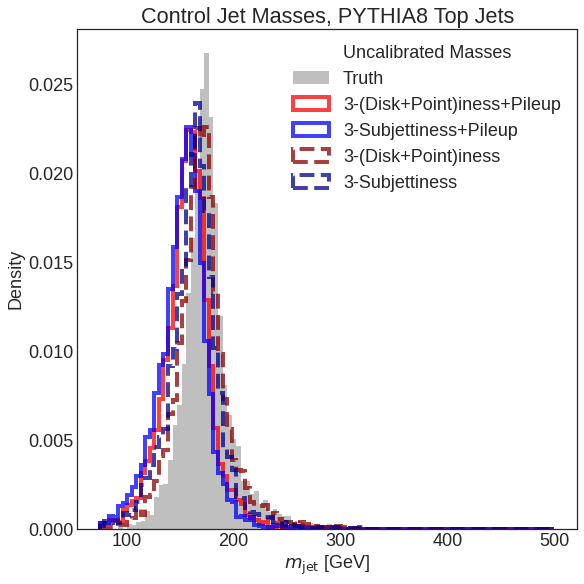

In [6]:
pileup = True
calibrate = True
pu_string = "PU" if pileup else "no_PU"



mass_dict = np.load("data/masses_%s.npy" % pu_string, allow_pickle=True)[()]
pileup_dict = np.load("data/pileup_dict_%s.npy" % pu_string, allow_pickle=True)[()]
signal_norms = np.load("data/signal_norms_PU.npy")



print(mass_dict.keys(), pileup_dict.keys())

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


bins = 100
lims = [75, 500]

truth_mass = 175.8501377538111

if calibrate:
    bias_dict = {"3-Subjettiness" : 163.34795415158527 - truth_mass,
             "3-Point-Diskiness" : 170.3481869192073 - truth_mass,
            #  "3-Point-Ellipsiness" : 171.50929094320688 - truth_mass,
             "3-Subjettiness Plus Pileup" : 152.8010507139326 - truth_mass,
             "3-Point-Diskiness Plus Pileup": 160.1563454258016 - truth_mass,
            #  "3-Point-Ellipsiness Plus Pileup": 159.79685189260715 - truth_mass,
             }
else:
    bias_dict = {"3-Subjettiness" : 0.0,
             "3-Point-Diskiness" : 0.0,
            #  "3-Point-Ellipsiness" : 0.0,
             "3-Subjettiness Plus Pileup" : 0.0,
             "3-Point-Diskiness Plus Pileup": 0.0,
            #  "3-Point-Ellipsiness Plus Pileup": 0.0,
             }


for obs in list(observables.keys()):
    mean  = np.mean(mass_dict[obs]) - truth_mass
    std = np.std(mass_dict[obs])
    print(obs, mean, std)


print(np.mean(mass_dict["Truth"]))

plt.hist(mass_dict["Truth"], bins = bins, range = lims, label = "Truth", alpha = 0.25,  histtype="stepfilled", color = "black", lw = 4, density = True)



def hist_to_points(string, marker, color, label):
    counts, bin_edges = np.histogram(mass_dict[string] - bias_dict[string], range=lims, bins = bins, density = True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.plot(bin_centers[counts > 0], counts[counts > 0], marker = marker, color = color, label=label , ls = "none")


# hist_to_points("3-Point-Diskiness Plus Pileup", "o", "red", "3-(Disk+Point)iness + Pileup")
# hist_to_points("3-Subjettiness Plus Pileup", "o", "blue", "3-Subjettiness + Pileup")
# hist_to_points("3-Point-Diskiness", "^", "darkred", "3-(Disk+Point)iness")
# hist_to_points("3-Subjettiness", "^", "darkblue", "3-Subjettiness")

plt.hist(mass_dict["3-Point-Diskiness Plus Pileup"] - bias_dict["3-Point-Diskiness Plus Pileup"], label = "%s" %("3-(Disk+Point)iness+Pileup"), histtype="step", lw = 4, range=lims, bins = bins, color = "red",  density = True, alpha= 0.75)
plt.hist(mass_dict["3-Subjettiness Plus Pileup"] - bias_dict["3-Subjettiness Plus Pileup"], label = "%s" %("3-Subjettiness+Pileup"), histtype="step", lw = 4, range=lims, bins = bins, color = "blue",  density = True, alpha= 0.75)

plt.hist(mass_dict["3-Point-Diskiness"] - bias_dict["3-Point-Diskiness"], label = "%s" %("3-(Disk+Point)iness"), histtype="step", lw = 4, range=lims, bins = bins, color = 'darkred', ls = "--", density = True, alpha= 0.75)
plt.hist(mass_dict["3-Subjettiness"] - bias_dict["3-Subjettiness"], label = "%s" %("3-Subjettiness"), histtype="step", lw = 4, range=lims, bins = bins, color = "darkblue", ls = "--", density = True, alpha= 0.75)






if pileup:
    plt.hist(mass_dict["Uncorrected"], bins = bins, range = lims, label = "Contaminated", alpha = 1.0, histtype="step", color = "black",  lw = 4, density = True, zorder = 1)



plt.legend(ncol = 1, frameon = False, title = "Calibrated Masses" if calibrate else "Uncalibrated Masses")
plt.xlabel(r"$m_{\rm jet}$ [GeV]")
plt.ylabel("Density")
plt.title("Pileup Jet Masses, PYTHIA8 Top Jets" if pileup else "Control Jet Masses, PYTHIA8 Top Jets")
plt.savefig("Plots/pileup.pdf" if pileup else "Plots/pileup_control.pdf" )
plt.show()
plt.close()




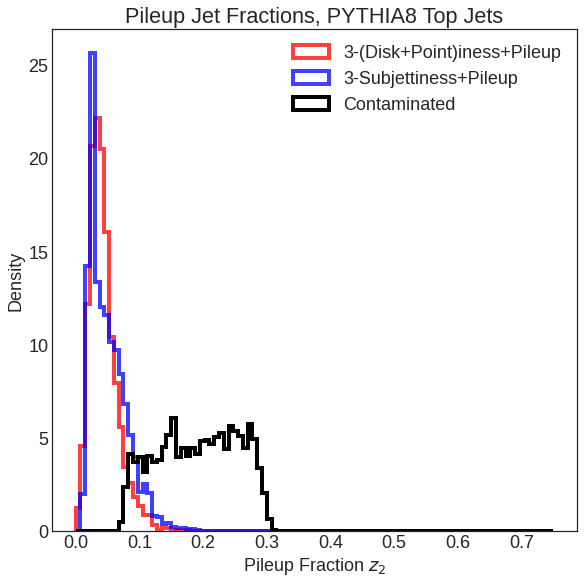

/tmp/ipykernel_7262/1495482065.py:34: RuntimeWarning: invalid value encountered in sqrt
  m_PU2 = np.sqrt(mass_dict["Uncorrected"]**2 - mass_dict["Truth"]**2)
/tmp/ipykernel_7262/1495482065.py:53: RuntimeWarning: invalid value encountered in sqrt
  subjet_m_PU21  = np.sqrt(mass_dict["Uncorrected"]**2 -(mass_dict["3-Subjettiness Plus Pileup"] - bias_dict["3-Subjettiness Plus Pileup"])**2)
/tmp/ipykernel_7262/1495482065.py:54: RuntimeWarning: invalid value encountered in sqrt
  disk_m_PU21  =  np.sqrt(mass_dict["Uncorrected"]**2   - (mass_dict["3-Point-Diskiness Plus Pileup"] - bias_dict["3-Point-Diskiness Plus Pileup"])**2)
/home/rikab/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


nan nan


TypeError: '<=' not supported between instances of 'str' and 'float'

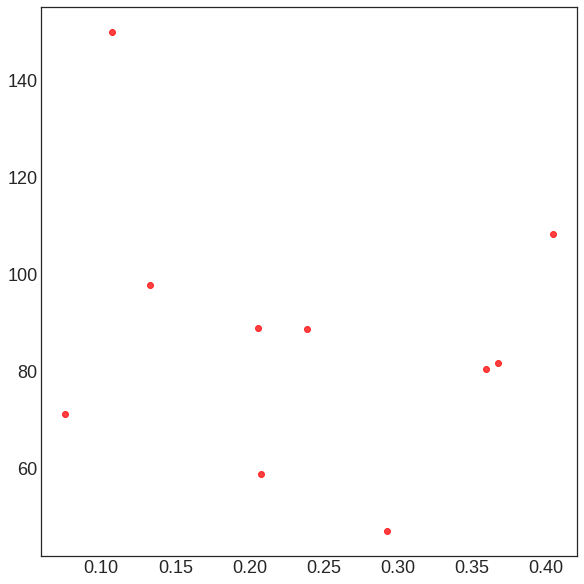

In [8]:
# Energy fractions
lims = [0,0.75]
_, signal_norm_temp = normalize_events(signal, return_norm= True)
fracs = 1 - (np.array(signal_norm_temp) / np.array(signal_norms1))

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

plt.hist(pileup_dict["3-Point-Diskiness Plus Pileup"] , label = "%s" %("3-(Disk+Point)iness+Pileup"), histtype="step",  range = lims, lw = 4, bins = bins, density = True, color = "red", alpha = 0.75)
plt.hist(pileup_dict["3-Subjettiness Plus Pileup"] , label = "%s" %("3-Subjettiness+Pileup"), histtype="step",  range = lims, lw = 4, bins = bins, density = True, color = "blue", alpha = 0.75)
plt.hist(fracs, bins = bins, histtype="step", label = "Contaminated", range = lims, lw = 4, density = True, color = "black")
# plt.hist(pileup_dict["3-Point-Ellipsiness Plus Pileup"] , label = "%s" %("3-(Ellipse+Point)iness + Pileup"), histtype="step",  range = lims, lw = 4, bins = bins, density = True, color = "green", alpha = 0.75)

plt.legend(frameon = False,)
plt.xlabel(r"Pileup Fraction $z_2$")
plt.ylabel("Density")
plt.title("Pileup Jet Fractions, PYTHIA8 Top Jets")
plt.savefig("Plots/pileup_fractions.pdf")
plt.show()
plt.close()





plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

# 2nd plot 
k = 2/3
R = 0.8
m = 175

m_PU2 = np.sqrt(mass_dict["Uncorrected"]**2 - mass_dict["Truth"]**2)



def correction(E, z):

    E_PU = E * z
    E_top = E * (1-z)

    m_pileup2 = k * R**2 * E_PU**2


    m_PU2 = m_pileup2 + 2*E_PU * E_top * (1 - np.sqrt(1 - m**2 / (E_top)**2) * np.sqrt(1 - m_pileup2 / (E_PU)**2))
    return m_PU2

subjet_m_PU2  = np.sqrt(correction(signal_norms, 1*pileup_dict["3-Subjettiness Plus Pileup"] - bias_dict["3-Subjettiness Plus Pileup"]))
disk_m_PU2  = np.sqrt( correction(signal_norms, 1*pileup_dict["3-Point-Diskiness Plus Pileup"] - bias_dict["3-Point-Diskiness Plus Pileup"]))
# ellipse_m_PU2  = np.sqrt( correction(signal_norms, 1*pileup_dict["3-Point-Ellipsiness Plus Pileup"] - bias_dict["3-Point-Ellipsiness Plus Pileup"]))

subjet_m_PU21  = np.sqrt(mass_dict["Uncorrected"]**2 -(mass_dict["3-Subjettiness Plus Pileup"] - bias_dict["3-Subjettiness Plus Pileup"])**2)
disk_m_PU21  =  np.sqrt(mass_dict["Uncorrected"]**2   - (mass_dict["3-Point-Diskiness Plus Pileup"] - bias_dict["3-Point-Diskiness Plus Pileup"])**2)
# ellipse_m_PU21  =  np.sqrt(mass_dict["Uncorrected"]**2   - (mass_dict["3-Point-Ellipsiness Plus Pileup"] - bias_dict["3-Point-Ellipsiness Plus Pileup"])**2)

plot_N = 25
# plt.scatter(m_PU2[:plot_N], subjet_m_PU2[:plot_N], color = "Blue", label = "3-Subjettiness + Pileup", alpha = 0.75)
# plt.scatter(m_PU2[:plot_N], disk_m_PU2[:plot_N], color = "red", label = "3-(Disk+Point)iness + Pileup", alpha = 0.75)


def average_residual(arr):

    return np.sqrt(np.nanmean(np.square(m_PU2 - arr)))

def resolution(arr):

    return np.std(m_PU2 - arr)

subjet_residual = resolution(subjet_m_PU21)
disk_residual = resolution(disk_m_PU21)
# ellipse_residual = resolution(ellipse_m_PU21)
print(subjet_residual, disk_residual)


plt.errorbar(m_PU2[:plot_N], disk_m_PU21[:plot_N], yerr = 0, xerr=disk_residual*np.ones_like(disk_m_PU21[:plot_N]), color = "red", label = "3-(Disk+Point)iness+Pileup, $\hat{\sigma} = %.1f$ GeV" % disk_residual, alpha = 0.75,fmt='o')
plt.errorbar(m_PU2[:plot_N], subjet_m_PU21[:plot_N], yerr = 0, xerr=subjet_residual*np.ones_like(disk_m_PU21[:plot_N]), color = "blue", label = "3-Subjettiness+Pileup, $\hat{\sigma} = %.1f$ GeV" % subjet_residual, alpha = 0.75,fmt='o')
# plt.errorbar(m_PU2[:plot_N], ellipse_m_PU21[:plot_N], yerr = 0, xerr=ellipse_residual*np.ones_like(ellipse_m_PU21[:plot_N]), color = "green", label = "3-(Ellipse+Point)iness + Pileup, $\hat{\sigma} = %.1f$ GeV" % ellipse_residual, alpha = 0.75,fmt='o')


# plt.errorbar(m_PU2[:plot_N], subjet_m_PU2[:plot_N], yerr = 0, xerr=subjet_residual*np.ones_like(disk_m_PU21[:plot_N]), color = "darkblue", label = "3-Subjettiness + Pileup, $\hat{\sigma} = %.1f$ GeV" % subjet_residual, alpha = 0.75,fmt='o')
# plt.errorbar(m_PU2[:plot_N], disk_m_PU2[:plot_N], yerr = 0, xerr=disk_residual*np.ones_like(disk_m_PU21[:plot_N]), color = "darkred", label = "3-(Disk+Point)iness + Pileup, $\hat{\sigma} = %.1f$ GeV" % disk_residual, alpha = 0.75,fmt='o')


# Best fits
subjet_fit = np.polyfit(m_PU2, subjet_m_PU21, deg = 1)
disk_fit = np.polyfit(m_PU2, disk_m_PU21, deg = 1)
# ellipse_fit = np.polyfit(m_PU2, ellipse_m_PU21, deg = 1)


x = np.linspace(100, 3000, 100)
plt.plot(x, x, ls = "--", alpha = 0.5, color = "grey", lw = 2)
# plt.plot(x, subjet_fit[0]*x + subjet_fit[1], ls = "--", alpha = 0.5, color = "blue", lw = 2)
# plt.plot(x, disk_fit[0]*x + disk_fit[1], ls = "--", alpha = 0.5, color = "red", lw = 2)
print(subjet_fit[1], subjet_fit[0])
print(disk_fit[1], disk_fit[0])
# print(ellipse_fit[1], ellipse_fit[0])


plt.xlim(100, 450)
plt.ylim(100, 450)
plt.xlabel(r"$\sqrt{\Delta m_{\rm PU}^2} = \sqrt{m_{\rm jet}^2 - \Delta m_{\rm top}^2}$ [GeV]")
plt.ylabel(r"$\sqrt{\Delta \hat{m}_{\rm PU}^2} = \sqrt{m_{\rm jet}^2 - \Delta \hat{m}_{\rm top}^2(z_2)}$ [GeV]")
plt.title("Pileup Jet Corrections, PYTHIA8 Top Jets")
plt.legend(frameon = False, loc = "upper left", title = "Calibrated Masses")
plt.savefig("Plots/pileup_biases.pdf")
plt.show()
plt.close()

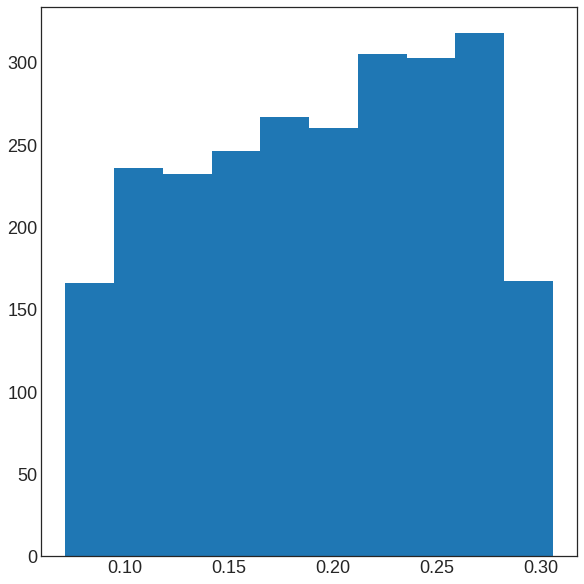

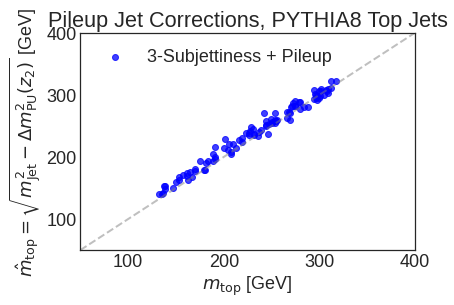

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

# 2nd plot 
k = 1/3
R = 0.8
m = 175

m_PU2 = np.sqrt(signal_pu_mass**2 - signal_mass**2)
_, signal_norms_pre = normalize_events(signal, return_norm=True)
zs_true = (np.array(signal_norms1) - np.array(signal_norms_pre) ) / np.array(signal_norms1)

plt.hist(zs_true)
plt.show()
plt.close()

def correction(E, z):

    E_PU = E * z
    E_top = E * (1-z)

    m_pileup2 = k * R**2 * E_PU**2


    m_PU2 = m_pileup2 + 2*2* E_PU * E_top * (1 - np.sqrt(1 - m**2 / (E_top)**2) * np.sqrt(1 - m_pileup2 / (E_PU)**2))
    return m_PU2

true_m_PU2 = np.sqrt(correction(np.array(signal_norms1), zs_true))



subjet_m_PU2  = np.sqrt(correction(signal_norms, pileup_dict["3-Subjettiness Plus Pileup"]))
disk_m_PU2  = np.sqrt( correction(signal_norms, pileup_dict["3-Point-Diskiness Plus Pileup"]))

# subjet_m_PU2  = mass_dict["3-Subjettiness Plus Pileup"] + 10 + 0*np.sqrt(mass_dict["Uncorrected"]**2 - correction(signal_norms, pileup_dict["3-Subjettiness Plus Pileup"]))
# disk_m_PU2  = mass_dict["3-Point-Diskiness Plus Pileup"] + 10 + 0*np.sqrt(mass_dict["Uncorrected"]**2   - correction(signal_norms, pileup_dict["3-Point-Diskiness Plus Pileup"]))

plot_N = 100
plt.scatter(m_PU2[:plot_N], true_m_PU2[:plot_N], color = "Blue", label = "3-Subjettiness + Pileup", alpha = 0.75)
# plt.scatter(m_PU2[:plot_N], disk_m_PU2[:plot_N], color = "red", label = "3-(Disk+Point)iness + Pileup", alpha = 0.75)

x = np.linspace(50, 3000, 100)
plt.plot(x, x, ls = "--", alpha = 0.5, color = "grey", lw = 2)

plt.xlim(50, 400)
plt.ylim(50, 400)
plt.xlabel(r"$m_{\rm top}$ [GeV]")
plt.ylabel(r"$\hat{m}_{\rm top} = \sqrt{m_{\rm Jet}^2 - \Delta m_{\rm PU}^2(z_2)}$ [GeV]")
plt.title("Pileup Jet Corrections, PYTHIA8 Top Jets")
plt.legend(frameon = False)